# MNIST手写体识别示例

In [1]:
import numpy as np
import torch
from torchvision.datasets import mnist # 导入 pytorch 内置的 mnist 数据

from torch import nn
from torch.autograd import Variable

## Step1-认识MNIST 数据集
mnist数据集，其来自美国国家标准与技术研究所, National Institute of Standards and Technology (NIST)。 训练集 (training set) 由来自 250 个不同人手写的数字构成, 其中 50% 是高中学生, 50% 来自人口普查局 (the Census Bureau) 的工作人员，一共有 60000 张图片。 测试集(test set) 也是同样比例的手写数字数据，一共有 10000 张图片。

每张图片大小是 28 x 28 的灰度图，如下

![](https://ws3.sinaimg.cn/large/006tKfTcly1fmlx2wl5tqj30ge0au745.jpg)

所以我们的任务就是给出一张图片，我们希望区别出其到底属于 0 到 9 这 10 个数字中的哪一个。

### 多分类问题
前面我们讲过二分类问题，现在处理的问题更加复杂，是一个 10 分类问题，统称为多分类问题。

In [2]:
# 使用内置函数下载 mnist 数据集
train_set = mnist.MNIST('./../../dataset', train=True, download=False)
test_set = mnist.MNIST('./../../dataset', train=False, download=False)

我们可以看看其中的一个数据是什么样子的

In [3]:
a_data, a_label = train_set[17]

In [4]:
a_data

In [5]:
a_label

8

这里的读入的数据是 PIL 库中的格式，我们可以非常方便地将其转换为 numpy array

In [6]:
a_data = np.array(a_data, dtype='float32')
print(a_data.shape)

(28, 28)


这里我们可以看到这种图片的大小是 28 x 28

In [7]:
print(a_data)

[[   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
     0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
     0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
     0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
     0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
     0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
     0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
     0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
     0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
     0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
     0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
     0.    0.    0.    0.    0.    0.    0.   11.  

我们可以将数组展示出来，里面的 0 就表示黑色，255 表示白色

## Step2-加载数据

### 使用transform变换

对于神经网络，我们第一层的输入就是 28 x 28 = 784，所以必须将得到的数据我们做一个变换，使用 reshape 将他们拉平成一个一维向量

In [8]:
def data_tf(x):
    x = np.array(x, dtype='float32') / 255
    x = (x - 0.5) / 0.5 # 标准化，这个技巧之后会讲到
    x = x.reshape((-1,)) # 拉平
    x = torch.from_numpy(x)
    return x

train_set = mnist.MNIST('./../../dataset', train=True, transform=data_tf, download=False) 
test_set = mnist.MNIST('./../../dataset', train=False, transform=data_tf, download=False)

In [9]:
a, a_label = train_set[0]
print(a.shape)
print(a_label)

torch.Size([784])
5


### 使用PyTorch的DataLoader

In [10]:
from torch.utils.data import DataLoader
# 使用 pytorch 自带的 DataLoader 定义一个数据迭代器
train_data = DataLoader(train_set, batch_size=64, shuffle=True)
test_data = DataLoader(test_set, batch_size=128, shuffle=False)

使用这样的数据迭代器是非常有必要的，如果数据量太大，就无法一次将他们全部读入内存，所以需要使用 python 迭代器，每次生成一个批次的数据

In [11]:
a, a_label = next(iter(train_data))

In [12]:
# 打印出一个批次的数据大小
print(a.shape)
print(a_label.shape)

torch.Size([64, 784])
torch.Size([64])


## Step3-定义网络模型

In [13]:
# 使用 Sequential 定义多层感知器
net = nn.Sequential(
    nn.Linear(784, 400),
    nn.ReLU(),
    nn.Linear(400, 200),
    nn.ReLU(),
    nn.Linear(200, 100),
    nn.ReLU(),
    nn.Linear(100, 10)
)

In [14]:
net

Sequential(
  (0): Linear(in_features=784, out_features=400)
  (1): ReLU()
  (2): Linear(in_features=400, out_features=200)
  (3): ReLU()
  (4): Linear(in_features=200, out_features=100)
  (5): ReLU()
  (6): Linear(in_features=100, out_features=10)
)

## Step4-训练模型

### 损失函数：交叉熵

交叉熵衡量两个分布相似性的一种度量方式，前面讲的二分类问题的 loss 函数就是交叉熵的一种特殊情况，交叉熵的一般公式为

$$
cross\_entropy(p, q) = E_{p}[-\log q] = - \frac{1}{m} \sum_{x} p(x) \log q(x)
$$

对于二分类问题我们可以写成

$$
-\frac{1}{m} \sum_{i=1}^m (y^{i} \log sigmoid(x^{i}) + (1 - y^{i}) \log (1 - sigmoid(x^{i}))
$$

In [15]:
# 定义 loss 函数
criterion = nn.CrossEntropyLoss()

### 优化方式：随机梯度下降

In [16]:
optimizer = torch.optim.SGD(net.parameters(), 1e-1) # 使用随机梯度下降，学习率 0.1

### 训练过程

In [17]:
# 开始训练
losses = []
acces = []
eval_losses = []
eval_acces = []

for e in range(20):
    train_loss = 0
    train_acc = 0
    net.train()
    for im, label in train_data:
        im = Variable(im)
        label = Variable(label)
        # 前向传播
        out = net(im)
        loss = criterion(out, label)
        # 反向传播
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # 记录误差
        train_loss += loss.data[0]
        # 计算分类的准确率
        _, pred = out.max(1)
        num_correct = (pred == label).sum().data[0]
        acc = float(num_correct) / im.shape[0]
        train_acc += acc
        
    losses.append(float(train_loss) / len(train_data))
    acces.append(float(train_acc) / len(train_data))
    # 在测试集上检验效果
    eval_loss = 0
    eval_acc = 0
    net.eval() # 将模型改为预测模式
    for im, label in test_data:
        im = Variable(im)
        label = Variable(label)
        out = net(im)
        loss = criterion(out, label)
        # 记录误差
        eval_loss += loss.data[0]
        # 记录准确率
        _, pred = out.max(1)
        num_correct = (pred == label).sum().data[0]
        acc = float(num_correct) / im.shape[0]
        eval_acc += acc
        
    eval_losses.append(float(eval_loss) / len(test_data))
    eval_acces.append(float(eval_acc) / len(test_data))
    print('epoch: {}, Train Loss: {:.6f}, Train Acc: {:.6f}, Eval Loss: {:.6f}, Eval Acc: {:.6f}'
          .format(e, float(train_loss) / len(train_data), float(train_acc) / len(train_data), 
                     float(eval_loss) / len(test_data), float(eval_acc) / len(test_data)))

epoch: 0, Train Loss: 0.519016, Train Acc: 0.834638, Eval Loss: 0.361309, Eval Acc: 0.883703
epoch: 1, Train Loss: 0.169951, Train Acc: 0.947561, Eval Loss: 0.128038, Eval Acc: 0.959652
epoch: 2, Train Loss: 0.117140, Train Acc: 0.963070, Eval Loss: 0.187929, Eval Acc: 0.942840
epoch: 3, Train Loss: 0.093299, Train Acc: 0.970682, Eval Loss: 0.434929, Eval Acc: 0.865309
epoch: 4, Train Loss: 0.075445, Train Acc: 0.976079, Eval Loss: 0.180311, Eval Acc: 0.944126
epoch: 5, Train Loss: 0.063380, Train Acc: 0.979977, Eval Loss: 0.080402, Eval Acc: 0.974585
epoch: 6, Train Loss: 0.052383, Train Acc: 0.982459, Eval Loss: 0.080593, Eval Acc: 0.975178
epoch: 7, Train Loss: 0.046333, Train Acc: 0.985075, Eval Loss: 0.081051, Eval Acc: 0.974684
epoch: 8, Train Loss: 0.036813, Train Acc: 0.988106, Eval Loss: 0.068934, Eval Acc: 0.980024
epoch: 9, Train Loss: 0.037258, Train Acc: 0.988073, Eval Loss: 0.073599, Eval Acc: 0.977551
epoch: 10, Train Loss: 0.030693, Train Acc: 0.989855, Eval Loss: 0.066

### 画出 loss 曲线和 准确率曲线

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline

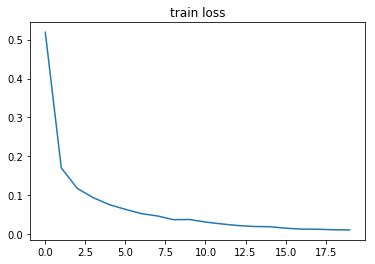

In [19]:
plt.title('train loss')
plt.plot(np.arange(len(losses)), losses)

Text(0.5,1,u'train acc')

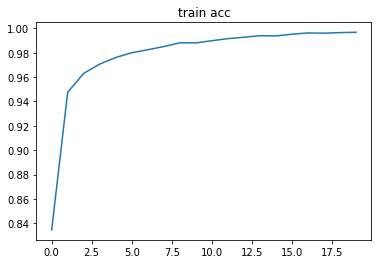

In [20]:
plt.plot(np.arange(len(acces)), acces)
plt.title('train acc')

Text(0.5,1,u'test loss')

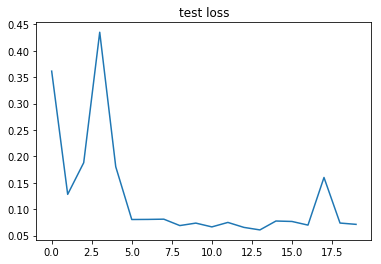

In [21]:
plt.plot(np.arange(len(eval_losses)), eval_losses)
plt.title('test loss')

Text(0.5,1,u'test acc')

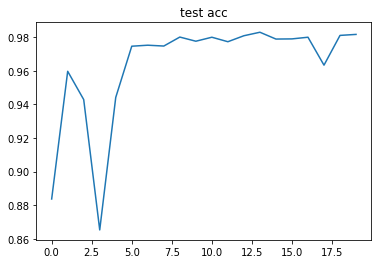

In [22]:
plt.plot(np.arange(len(eval_acces)), eval_acces)
plt.title('test acc')

可以看到我们的三层网络在训练集上能够达到 99.9% 的准确率，测试集上能够达到 98.20% 的准确率

**小练习：看一看上面的训练过程，看一下准确率是怎么计算出来的，特别注意 max 这个函数**

**自己重新实现一个新的网络，试试改变隐藏层的数目和激活函数，看看有什么新的结果**